# Train Eduge Classifier

This notebook trains a fine-tuned classifier to predict news category (politics, culture, etc.) using the Eduge dataset.

## Library Installs and Imports

We will need several libraries to get started. Each should be installed and upgraded to ensure it works. This notebook was created in February 2020 and should work with the following major verisons:

- Fast.ai version 2.x
- Fastcore version: 1.x
- Pandas version: 1.x
- Numpy version: 1.x

In [ ]:
!pip install -Uqq torchtext==0.8.0
!pip install -Uqq fastai
!pip install -Uqq fastcore
!pip install -Uqq pandas==1.1.0

     |████████████████████████████████| 7.0MB 1.2MB/s 
     |████████████████████████████████| 194kB 5.9MB/s 
     |████████████████████████████████| 12.8MB 23.0MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 10.5MB 5.6MB/s 


In [ ]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.2.7
Fastcore version: 1.3.19


In [ ]:
from fastai.text.all import *
from fastai.callback.progress import CSVLogger
import pandas as pd
import numpy as np
print('Pandas version:', pd.__version__)
print('numpy version:', np.__version__)

Pandas version: 1.1.5
numpy version: 1.19.5


In [ ]:
!pip install -Uqq sentencepiece!=0.1.90,!=0.1.91

     |████████████████████████████████| 1.2MB 5.8MB/s 


We will be using Google Drive to store our files. Please change the directory for the `cd` command to wherever your notebook is located. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/DataScience/NLP/02_mongolian_language_model'

/content/drive/MyDrive/DataScience/NLP/02_mongolian_language_model


In [ ]:
!nvidia-smi

Wed Mar 17 08:06:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataScience/NLP/01_eduge_classification/data/news.csv')

In [ ]:
df = df.rename(columns={'news':'text'})

In [ ]:
np.random.seed(42)

In [ ]:
df['is_valid'] = np.random.choice([0,1], size=len(df), p=[0.9, 0.1])

In [ ]:
df.head(2)

,text,label,is_valid
0,"Киноны кадраас «Юрийн галавын үе» кино прокатад тавигдсныхаа дараах эхний амралтын өдрөөр хамгийн их орлого оллоо гэж Business Insider хэвлэл мэдээлэв. Хойд Америкт л гэхэд эхний амралтын өдрүүдэд 204,6 сая доллар цуглуулж чадлаа. Гадаад орнуудын үзүүлэлт нь 307,2 сая ам.доллар байв. Нийт кассын орлого 511,8 сая ам.доллар болжээ. Энэхүү үзүүлэлт нь Universal кино компанийн дээд амжилт төдийгүй дэлхийн кино аж үйлдвэрийн томоохон үсрэлт боллоо. Үүнээс өмнө амралтын эхний өдрүүдэд 500 сая долларын босго давсан их мөнгө цуглуулж байсан түүх байхгүй. «Гарри Поттер ба үхлийн тахил: II хэсэг» 48...",урлаг соёл,0
1,"“Universal” кино компани Жадд Апатоугийн найруулж, “Lonely Island” гэдэг хошин шогийн хамтлагийнхны гол дүрүүдэд нь тоглож байгаа киног 2016 оны зургадугаар сарын 3-нд дэлгэцнээ гаргахаар төлөвлөсөн тухай The Hollywood Reporter мэдээлж байна. Шинэ киноны нэрийг одоохондоо өгөөгүй гэнэ. Кинонд инээдмийн жүжигчид Энди Сэмберг, Йорма Таккоме, Акива Шаффер нар тогложээ. Сүүлийн жилүүдэд гарч ирсэн баримтат киноны элэглэл нь шинэ кино болох ёстой. Энд Жастин Бибер, Кэти Перри нарын элэглэл хамгийн түрүүнд дүрслэгдэх аж. “Lonely Island” хошин шогийн хамтлагийнхан “Saturday Night Live” гэдэгт нэв...",урлаг соёл,1


### Build Dataloaders

In [ ]:
with open('models/mn_20_news_vocab_ft.pkl', 'rb') as f:
      vocab = pickle.load(f)

In [ ]:
bs = 128

In [ ]:
tok = SentencePieceTokenizer(lang='mn', sp_model='models/spm/ft/spm.model')

For some reason passing `label` to the `ColReader` for `get_y` threw an error. So I'm using the index of the column to reference the label.

In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', vocab=vocab, tok=tok), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader(1), 
                    splitter=ColSplitter())

In [ ]:
dls = dblocks.dataloaders(df)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch()

,text,category
0,"▁xxbos ▁монгол ▁улсын ▁ерөнхийлөгч ▁цахиа гийн ▁элбэгдорж ▁“ news ” ▁агентлагийн ▁урилгы г ▁хүлээн ▁авч , ▁уншигчдын ▁асуултад ▁хариуллаа . ▁морин ▁жилд ▁арван ▁жилийнхээ ▁ойг ▁тэмдэглэсэн ▁мэдээллийн ▁“ news ” ▁агентлаг ▁2004 -2014 ▁онд ▁шалгарсан ▁“ оны ▁хүмүүс ”- тэйгээ ▁цуврал ▁ярилцлага ▁хийж ▁байгаагийн ▁анхны ▁зочин ▁монгол ▁улсын ▁ерөнхийлөгч ▁цахиа гийн ▁элбэгдорж ▁боллоо . ▁өмнө ▁нь ▁“ нью с ▁агентлаг ”- аас ▁монгол ▁улсын ▁ерөнхийлөгчтэй ▁“ б ли ц -100” ▁гэсэн ▁сонирхолтой ▁ярилцлагыг ▁өрнүүлж , ▁олон ▁түмэндээ ▁хүргэж ▁байсан . ▁энэ ▁удаа ▁бид ▁хоёр ▁өдрийн ▁турш ▁уншигч д аасаа ▁асуулт ▁авсан ▁бөгөөд ▁уншигч д аас ▁нийт ▁461 ▁асуулт ▁ирснээс ▁40 ▁орчм ыг ▁багцлан , ▁ерөнхийлөгчид ▁тавьсан ▁юм . ▁ярилцлагыг ▁“ нью с ▁агентлаг ”- ийн ▁ерөнхий ▁редактор ▁ баярмагнай н ▁ тэмүүлэн ▁хөтлө в . ▁- ул ирч ▁байгаа ▁морин ▁жил ▁монголчуудад ▁маань ▁хэр ▁ээлтэй ▁байв , ▁таны ▁бодлоор . ▁бидний ▁олсон ▁ололт , ▁алдаа ▁юу ▁байв ? ▁- морин",улс төр
1,"▁xxbos ▁тун ▁удахгүй ▁уих - аар ▁“ шинэ ▁тө ­ мөр ▁зам ”- ын ▁цариг ийн ▁асуу д ­ лыг ▁хэлэлц э ▁н ▁шийдвэр лэ ▁нэ . ▁өргөн , ▁нарийн ▁гэсэн ▁хоёр ▁цариг ийн ▁аль ▁нь ▁монгол ▁улсад ▁ашиг ▁тус аа ▁өгөх ▁талаар ▁улс ▁төрчид ▁болон ▁бизнесийнхэн ▁маргалдан , ▁ширүүхэн ▁үзэл цэж ▁эхэллээ . ▁энэ ▁асуултын ▁хариулт ыг ▁бид ▁төмөр ▁замд ▁40 ▁шахам ▁жил ▁төмөр ▁замыг ▁арчлах , ▁шинээр ▁барих , ▁их ▁засвар ▁хийж ▁засч ▁шинэчлэх , ▁замын ▁зураг ▁төсөл , ▁тооцоо ▁судалгааг ▁хийж ▁ирсэн ▁ахмад ▁төмөр ▁ замчин , ▁инженер ▁б . лха наас үрэн тэй ▁ярилцлаа . ▁- төмөр ▁зам ▁барих ▁асуудал ▁өмнө ▁нь ▁ингэж ▁дуулиан ▁шуугиан ▁болж ▁байсангүй . ▁нарийн ▁цариг ▁хэрэгтэй ▁юу ? ▁эсвэл ▁өргөн ▁цариг ▁нь ▁ашигтай ▁юу ? ▁гэсэн ▁асуултын ▁хариуг ▁хүмүүс ▁яг ▁энэ ▁цаг ▁мөчид ▁ч ▁хайс аар ▁л ▁байна ? ▁- ▁би ▁өмнө ▁ч ▁бас ▁ярьж ▁л ▁байсан ▁даа . ▁далай д",эдийн засаг
2,"▁xxbos ▁"" өдрийн ▁сонин ""- ий ▁2014 . 09. 29- ний ▁дугаарт ▁нийтлэгдсэн ▁уих - ын ▁гишүүн ▁х . баттулгын ▁ярилцлагыг ▁зохиогч ийн ▁зөвшөөрөл тэйгөөр ▁нийтэлж ▁байна ▁ . ▁- хөгжлийн ▁бодлогоо ▁гаргаад ▁гадны ▁хөрөнгө ▁оруулагчдад ▁мессэж ▁болгон ▁өгөх ▁хэрэгтэй - ▁уих - ын ▁гишүүн ▁х . бат ­ тулга тай ▁ярилцлаа . ▁- шар ▁тивийн ▁орнууд ▁бүхэлд ээ ▁азийн ▁олимп доо ▁анхаарал ▁хандуулж ▁бай ­ на . ▁азийн ▁наадмын ▁ салхийг ▁жүдогийн хон ▁маш ▁амжилттай ▁хагалж ▁гурван ▁алт , ▁гурван ▁мөнгө , ▁ дөр ­ в өн ▁хүрэл ▁медальтай ▁өндөр ­ лүүлсэн . ▁жүдо ▁бөх ▁2008 ▁оны ▁олимп оос ▁хойш ▁илт ▁сэргэсэн ▁нь ▁таныг ▁холбооны ▁тэргүүнээр ▁ажилласан тай ▁сал шгүй ▁холбоотой ▁гэдэг . ▁та ▁холбоо гоо ▁ямар ▁чиглэлд ▁удирддаг ▁вэ ? ▁- дэлхийн ▁долоон ▁тэрбум ▁хүний ▁дөрвөн ▁тэрбум ▁нь ▁ази ▁тивд ▁амьдардаг . ▁тиймээс ▁ээлжит ▁олимп оо ▁зохион ▁бай ­ гуулж ▁байгаа ▁нь ▁ази ▁тивийн ▁том ▁амбиц ▁юм ▁уу",улс төр
3,"▁xxbos ▁уих - ын ▁гишүүн ▁л . эрдэнэчимэг , ▁"" өглөөний ▁хүн "" ▁ярилцлагын ▁булан , ▁2014 ▁монголчууд ▁бид ▁ архины ▁хор ▁уршгий г ▁хангалттай ▁л ▁ярьсан . ▁харин ▁энэ ▁хорт ▁зуршл ыг ▁бууруулах ▁зорилготой ▁хууль ▁энэ ▁хавр ын ▁чуулганаар ▁хэлэлцэгдэ нэ . ▁энэхүү ▁хууль ▁хэлэлцэгдэх ▁гэж ▁байгаатай ▁холбоотойгоор ▁эсрэг ▁байр ▁суурьтай ▁байгаа ▁лобби ▁бүлгүүд ▁хэвлэл ээр , ▁олон ▁нийтийн ▁сүлжээгээр ▁улам ▁бүр ▁идэвхжиж ▁байгаа ▁нь ▁ажиглагд саар ▁байна . ▁тэд ▁хуулийн ▁ямар ▁учир ▁утгатай г ▁сайн ▁мэдэхгүй дээ ▁ингэж ▁байна ▁уу ▁эсвэл ▁мэдс ээр ▁байж ▁ архины ▁хяналтын ▁тухай ▁хуулийг ▁санаатай ▁б аа лахаар ▁шаргуу ▁бичиж ▁байна ▁уу ▁гэдэг ▁сонирхолтой . ▁яах ▁аргагүй ▁цаг ▁үеийн ▁халуун ▁сэдэв ▁болоод ▁байгаа ▁энэхүү ▁хуулийн ▁гол ▁санаачлагчд ын ▁нэг ▁уих - ын ▁гишүүн ▁л . эрдэнэчимэг ийг ▁бид ▁"" өглөөний ▁хүн "" ▁ярилцлагын ▁булан даа ▁урьсан ▁юм . ▁бидний ▁ярианы ▁дийлэнх ▁хэсэг ▁архи , ▁тамхи тай ▁холбоотой . ▁ярих ▁л ▁ёстой ▁асуудал .",улс төр
4,"▁xxbos ▁ер ѳ н хий ▁сайд ▁н . алтанхуяг ▁засгийн ▁газрын хаа ▁бүтэц , ▁бүрэлдэхүүнийг ▁ ѳѳ рч л ѳ х ▁“ санаа ч лагаа ” ▁уих - д ▁оруулах аа ▁зарла снаар ▁нийгэм ▁даяар ▁хүлээлт ▁үү с лээ . ▁ ѳѳ рч л ѳ лт ▁хийхийг ▁удаа ▁дараа ▁шаардаж ▁ирсэн ▁ер ѳ н хийл ѳ гч ▁болон ▁с ѳ р ѳ г ▁хүчин

We can see the categories by looking into the `dls.vocab` object. The first element of `dls.vocab` is the vocabulary for the entire corpus. The second element is the categories.

In [ ]:
dls.vocab[1]

['байгал орчин', 'боловсрол', 'спорт', 'технологи', 'улс төр', 'урлаг соёл', 'хууль', 'эдийн засаг', 'эрүүл мэнд']

### Training

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                                 metrics=[accuracy]).to_fp16()

In [ ]:
notebook_path = Path('').absolute()

In [ ]:
learn.path = notebook_path

In [ ]:
learn.load_encoder(notebook_path/'models/mn_20_news_encoder_ft')

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.019054606556892395)

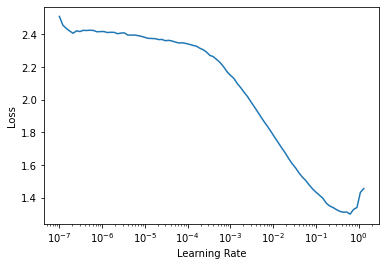

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-2

In [ ]:
cbs=[CSVLogger(fname='history_20_news_eduge_classification.csv')]

In [ ]:
learn.fine_tune(10, lr, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.351963,0.286612,0.905056,02:56


epoch,train_loss,valid_loss,accuracy,time
0,0.276890,0.219864,0.925976,04:27
1,0.255892,0.223976,0.930401,04:26
2,0.262783,0.215547,0.928658,04:25
3,0.221295,0.228666,0.927451,04:25
4,0.181627,0.212491,0.932278,04:25
5,0.166463,0.216551,0.934424,04:25
6,0.138220,0.226244,0.933217,04:27
7,0.086994,0.231021,0.934424,04:27
8,0.074472,0.243153,0.936167,04:27
9,0.077297,0.243899,0.935095,04:27


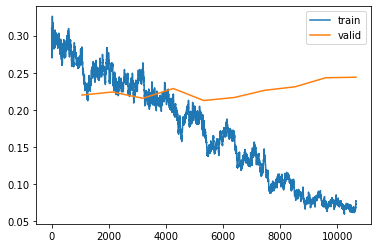

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export()